In [1]:
import os
import sys
from pathlib import Path

In [2]:
current_file_path = os.path.abspath('')
root_file_path = str(Path(current_file_path).parent)
sys.path.append(root_file_path)

In [3]:
from deep_globe_seg.helpers import list_subfolders_and_files, CFG, visualize, round_clip_0_1, denormalize, Dataset, get_preprocessing, get_training_augmentation, Dataloader

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.14 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations
2024-08-17 19:19:00.425892: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-17 19:19:00.495953: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-17 19:19:00.495987: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-17 19:19:00.498217: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory

In [4]:
# Define custom parameters
custom_dataset_params = {
    'img_size': (512, 512),
    'input_shape': (512, 512, 3),
}

custom_hyper_params = {
    'batch_size': 8,
    'learning_rate': 0.0001,
    'num_classes': 1,
    'epochs': 10
}

# Initialize the CFG class with custom parameters
configs = CFG(image_folder=os.path.join(root_file_path, 'data'),
                  saved_model_folder=os.path.join(root_file_path, 'saved_models'),
                  tensorboard_logs_path=os.path.join(root_file_path, 'logs'),
                  model_type='unet',
                  hyper_params= custom_hyper_params,
                  dataset_params= custom_dataset_params)

In [5]:
Path(configs.Path.saved_model_folder).mkdir(parents = True, exist_ok = True)
Path(configs.Path.tensorboard_logs_path).mkdir(parents = True, exist_ok = True)

In [6]:
# Replace 'your_base_folder_path' with the path to your base folder
list_subfolders_and_files(configs.Path.image_folder)

Subfolder: /home/jovyan/workspace/deepglobe-road-segmentation/data/valid
  100794_sat.jpg
  100905_sat.jpg
  102867_sat.jpg
  10417_sat.jpg
  106553_sat.jpg
  10678_sat.jpg
  107243_sat.jpg
  109245_sat.jpg
  11053_sat.jpg
  112600_sat.jpg
Subfolder: /home/jovyan/workspace/deepglobe-road-segmentation/data/test
  100393_sat.jpg
  100995_sat.jpg
  101982_sat.jpg
  10206_sat.jpg
  102240_sat.jpg
  102765_sat.jpg
  104859_sat.jpg
  105342_sat.jpg
  105546_sat.jpg
  105695_sat.jpg
Subfolder: /home/jovyan/workspace/deepglobe-road-segmentation/data/train
  100034_mask.png
  100034_sat.jpg
  100081_mask.png
  100081_sat.jpg
  100129_mask.png
  100129_sat.jpg
  100703_mask.png
  100703_sat.jpg
  100712_mask.png
  100712_sat.jpg


In [7]:
# Import CV packages
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import albumentations as A

# Import tensorflow, keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Import image segmentation package
import os
os.environ['SM_FRAMEWORK'] = "tf.keras"
import segmentation_models as sm

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

Segmentation Models: using `tf.keras` framework.


In [8]:
pd.read_csv(configs.Path.metadata)

,image_id,split,sat_image_path,mask_path
0,100034,train,train/100034_sat.jpg,train/100034_mask.png
1,100081,train,train/100081_sat.jpg,train/100081_mask.png
2,100129,train,train/100129_sat.jpg,train/100129_mask.png
3,100703,train,train/100703_sat.jpg,train/100703_mask.png
4,100712,train,train/100712_sat.jpg,train/100712_mask.png
...,...,...,...,...
8565,998829,test,test/998829_sat.jpg,NaN
8566,998928,test,test/998928_sat.jpg,NaN
8567,999518,test,test/999518_sat.jpg,NaN
8568,999651,test,test/999651_sat.jpg,NaN


In [9]:
# Read metadata and filter for training data
metadata_df = pd.read_csv(configs.Path.metadata)
metadata_df = metadata_df[metadata_df['split'] == 'train']
metadata_df = metadata_df.iloc[:15,:]

# Select relevant columns and update paths
metadata_df = metadata_df[['image_id', 'sat_image_path', 'mask_path']]
metadata_df['sat_image_path'] = metadata_df['sat_image_path'].apply(lambda img_pth: os.path.join(configs.Path.image_folder, img_pth))
metadata_df['mask_path'] = metadata_df['mask_path'].apply(lambda mask_pth: os.path.join(configs.Path.image_folder, mask_pth))

# Shuffle DataFrame
metadata_df = metadata_df.sample(frac=1, random_state=9).reset_index(drop=True)

# Split into train, validation, and test sets (80/10/10 split)
test_df = metadata_df.sample(frac=0.1, random_state=9)
remaining_df = metadata_df.drop(test_df.index)
valid_df = remaining_df.sample(frac=0.1, random_state=9)
train_df = remaining_df.drop(valid_df.index)

# Print informative message about dataset split
print("Dataset successfully loaded and split into training, validation, and test sets:")
print(f"Number of samples in training set: {len(train_df)}")
print(f"Number of samples in validation set: {len(valid_df)}")
print(f"Number of samples in test set: {len(test_df)}")

Dataset successfully loaded and split into training, validation, and test sets:
Number of samples in training set: 12
Number of samples in validation set: 1
Number of samples in test set: 2


In [10]:
metadata_df.head(3)

,image_id,sat_image_path,mask_path
0,10246,/home/jovyan/workspace/deepglobe-road-segmenta...,/home/jovyan/workspace/deepglobe-road-segmenta...
1,100867,/home/jovyan/workspace/deepglobe-road-segmenta...,/home/jovyan/workspace/deepglobe-road-segmenta...
2,101296,/home/jovyan/workspace/deepglobe-road-segmenta...,/home/jovyan/workspace/deepglobe-road-segmenta...


In [11]:
train_df.head(3)

,image_id,sat_image_path,mask_path
0,10246,/home/jovyan/workspace/deepglobe-road-segmenta...,/home/jovyan/workspace/deepglobe-road-segmenta...
1,100867,/home/jovyan/workspace/deepglobe-road-segmenta...,/home/jovyan/workspace/deepglobe-road-segmenta...
2,101296,/home/jovyan/workspace/deepglobe-road-segmenta...,/home/jovyan/workspace/deepglobe-road-segmenta...


In [12]:
valid_df.head(3)

,image_id,sat_image_path,mask_path
8,100081,/home/jovyan/workspace/deepglobe-road-segmenta...,/home/jovyan/workspace/deepglobe-road-segmenta...


In [13]:
test_df.head(3)

,image_id,sat_image_path,mask_path
13,102408,/home/jovyan/workspace/deepglobe-road-segmenta...,/home/jovyan/workspace/deepglobe-road-segmenta...
7,101225,/home/jovyan/workspace/deepglobe-road-segmenta...,/home/jovyan/workspace/deepglobe-road-segmenta...


In [14]:
class_dict = pd.read_csv(configs.Path.class_dict)
# Get class names
class_names = class_dict['name'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['road', 'background']
Class RGB values:  [[255, 255, 255], [0, 0, 0]]


In [15]:
BACKBONE = 'resnet50'
BATCH_SIZE = configs.HyperParameter.batch_size
CLASSES = ['road']
LR = configs.HyperParameter.learning_rate
EPOCHS = configs.HyperParameter.epochs

In [16]:
preprocess_input = sm.get_preprocessing(BACKBONE)

In [17]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

2024-08-17 19:19:02.493550: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-17 19:19:02.548091: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-17 19:19:02.548346: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [18]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# Evaluation metrics
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimizer, loss and metrics inputs
model.compile(optimizer=optim, loss=total_loss, metrics=metrics)

In [19]:
# Dataset for train images
train_dataset = Dataset(
    train_df,
    shape=configs.Dataset.img_size,
    classes=CLASSES,
    preprocessing=get_preprocessing(preprocess_input),
    augmentation=get_training_augmentation(configs.Dataset.img_size)
)

# Dataset for validation images
valid_dataset = Dataset(
    valid_df,
    shape=configs.Dataset.img_size,
    classes=CLASSES,
    preprocessing=get_preprocessing(preprocess_input)
)

train_dataloader = Dataloader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloader(valid_dataset, batch_size=1, shuffle=False)

INFO:root:Initialized Dataset with 12 samples.
INFO:root:Initialized Dataset with 1 samples.


In [20]:
first_train_image = train_dataset[0]
first_valid_image = valid_dataset[0]

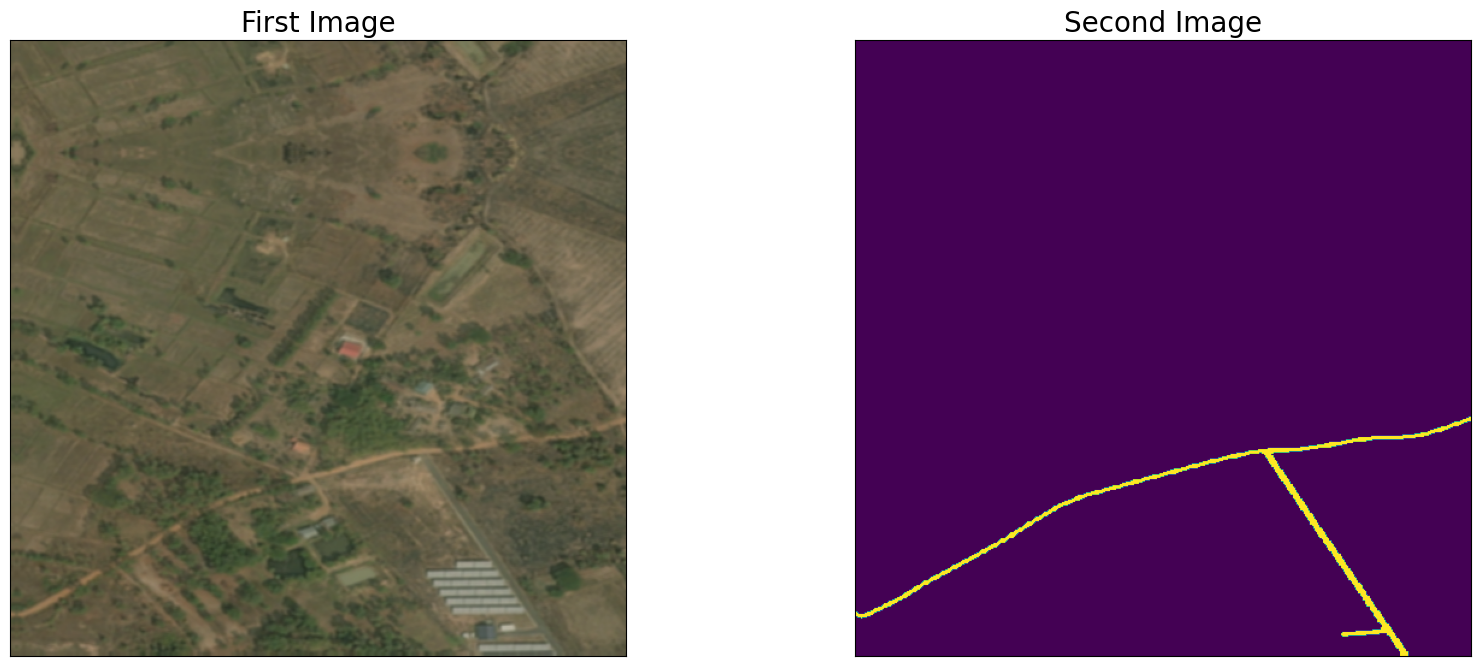

In [21]:
visualize(first_image=first_train_image[0], second_image=first_train_image[1])

In [22]:
first_batch = train_dataloader[0]

In [23]:
first_batch[0].shape

TensorShape([8, 512, 512, 3])

In [24]:
first_batch[1].shape

TensorShape([8, 512, 512, 1])

In [25]:
second_batch = train_dataloader[1]

In [26]:
second_batch[0].shape

TensorShape([4, 512, 512, 3])

In [27]:
second_batch[1].shape

TensorShape([4, 512, 512, 1])

In [28]:
len(train_dataloader)

2

In [29]:
# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, *configs.Dataset.img_size, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, *configs.Dataset.img_size, n_classes)

In [30]:
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint(configs.Path.model_save_path, save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.EarlyStopping(monitor='val_loss', 
                                  patience=3,
                                  verbose=1, 
                                  mode='min',
                                  restore_best_weights=True)
]

In [31]:
# train model
if os.path.isfile(configs.Path.model_save_path):
    print("INFO ===========Running the Partially Trained Model===============")
    model.load_weights(configs.Path.model_save_path)
    history = model.fit(
        train_dataloader,
        epochs=EPOCHS,
        callbacks=callbacks, 
        validation_data=valid_dataloader,
        verbose=1
    )
else:
    print("INFO ===========Running the Training of Model from Scratch===============")
    history = model.fit(
        train_dataloader, 
        epochs=EPOCHS,
        callbacks=callbacks, 
        validation_data=valid_dataloader,
        verbose=1
    )

INFO ===========Running the Training of Model from Scratch===============
Epoch 1/10


I0000 00:00:1723922373.567621    1539 service.cc:145] XLA service 0x7fcca8001e90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1723922373.567663    1539 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-08-17 19:19:34.322536: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-17 19:19:37.252417: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-08-17 19:19:46.606833: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 25.57GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-08-17 19:19:49.754063: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0

1/2 ━━━━━━━━━━━━━━━━━━━━ 1:31 92s/step - f1-score: 0.0499 - iou_score: 0.0256 - loss: 1.1169

I0000 00:00:1723922483.821818    1539 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_reduce_window_fusion_1', 276 bytes spill stores, 272 bytes spill loads



2/2 ━━━━━━━━━━━━━━━━━━━━ 146s 54s/step - f1-score: 0.0810 - iou_score: 0.0428 - loss: 1.0934 - val_f1-score: 0.0325 - val_iou_score: 0.0165 - val_loss: 1.0830 - learning_rate: 1.0000e-04
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 26s 4s/step - f1-score: 0.1297 - iou_score: 0.0702 - loss: 1.0467 - val_f1-score: 0.0277 - val_iou_score: 0.0141 - val_loss: 1.0818 - learning_rate: 1.0000e-04
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - f1-score: 0.0929 - iou_score: 0.0493 - loss: 1.0776 - val_f1-score: 0.0294 - val_iou_score: 0.0149 - val_loss: 1.0793 - learning_rate: 1.0000e-04
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - f1-score: 0.1016 - iou_score: 0.0546 - loss: 1.0688 - val_f1-score: 0.0368 - val_iou_score: 0.0188 - val_loss: 1.0780 - learning_rate: 1.0000e-04
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - f1-score: 0.1586 - iou_score: 0.0872 - loss: 1.0198 - val_f1-score: 0.0438 - val_iou_score: 0.0224 - val_loss: 1.0771 - learning_rate: 1.0000e-04
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━

In [32]:
history.history['loss']

[1.0816041231155396,
 1.0705081224441528,
 1.0676132440567017,
 1.0560001134872437,
 1.042288899421692,
 1.042829990386963,
 1.030570149421692,
 1.0212472677230835,
 1.0150794982910156,
 1.010362148284912]

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
# plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

# Plot training & validation loss values
# plt.subplot(122)
plt.figure(figsize=(30, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

plt.figure(figsize=(30, 5))
plt.plot(history.history['f1-score'])
plt.plot(history.history['val_f1-score'])
plt.title('Model loss')
plt.ylabel('f1-score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

In [ ]:
# load best weights
model.load_weights(cfg.Path.model_save_path) 

In [ ]:
scores = model.evaluate_generator(train_dataloader) # test_dataloader

print("Training loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean training {}: {:.5}".format(metric.__name__, value))

In [ ]:
scores = model.evaluate_generator(valid_dataloader) # test_dataloader

print("Validation loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean validation {}: {:.5}".format(metric.__name__, value))


In [ ]:
n = 3
# test_dataset
ids = np.random.choice(np.arange(len(valid_dataset)), size=n)

for i in ids:
    
    image, gt_mask = valid_dataset[i]  # test_dataset
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[..., 0].squeeze(),
        pr_mask=pr_mask[..., 0].squeeze(),
    )